In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import pinocchio as pin

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF

from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.description.builder import jps_graph2pinocchio_robot, jps_graph2pinocchio_robot_3d_constraints
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import ManipulabilityReward, ZRRReward
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT, URDFLinkCreater3DConstraints
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L, get_preset_by_index
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
from auto_robot_design.optimization.saver import ProblemSaver
from auto_robot_design.utils.configs import inertial_config_two_link_workspace, get_mesh_builder, inertial_config_two_link_six_trajectories, jacobian_config_two_link_workspace
from auto_robot_design.generator.user_generator.graph_generator import TopologyManager2D
from auto_robot_design.description.kinematics import JointPoint

TypeError: non-default argument 'relative_mutation_range' follows default argument

In [ ]:
builder, crag, soft_constrain, reward_manager = jacobian_config_two_link_workspace()

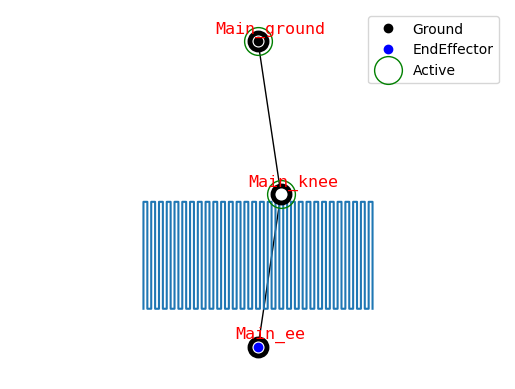

In [ ]:
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[50:, 0], trajectory[50:, 2])
gm = get_preset_by_index_with_bounds(-1)
values = gm.generate_central_from_mutation_range()
graph = gm.get_graph(values)
draw_joint_point(graph)
plt.savefig("trajectories.png")

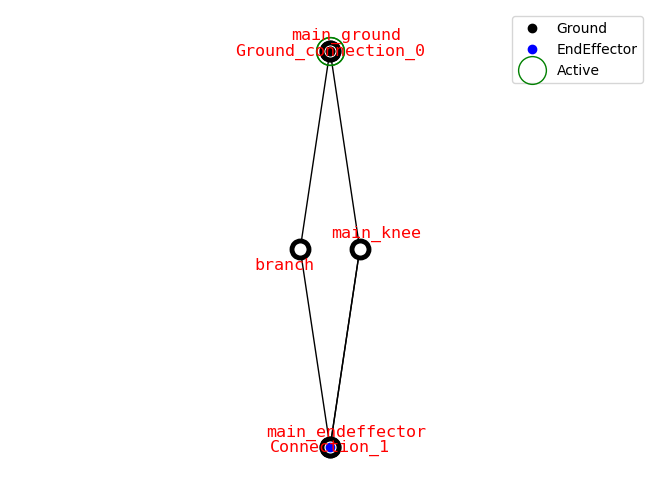

In [ ]:
tp = TopologyManager2D()
# creates ground connection
tp.add_connection(ground=True, self_mutation_range= [(-0.2001, 0.1999),None,(-0.1, 0.1)], dependent_mutation_range=[(-0.13,0.07),None,(-0.3,-0.1)])
main_ground_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=True, name='main_ground',attach_ground=True, attach_endeffector=False)
tp.add_absolute_node(jp=main_ground_jp, initial_coordinates=np.array([0, 0, 0]), mutation_range=[None,None,None], freeze_pos=np.array([0,0,0]))
main_knee_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_knee', attach_ground=False, attach_endeffector=False)
tp.add_absolute_node(jp=main_knee_jp, parent_branch_idx=0, initial_coordinates=[0.03, 0, -0.2], mutation_range=[None,None,(-0.1,0.1)], freeze_pos=np.array([0.03,0,None]))
# creates connection on the first link
tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.4,0.4)], dependent_mutation_range=[(-0.1,0.1),None,(-0.1,0.1)])
main_endeffector_jp = JointPoint(r = None, w=np.array([0, 1, 0]), active=False, name='main_endeffector',attach_ground=False, attach_endeffector=True)
tp.add_absolute_node(jp=main_endeffector_jp, parent_branch_idx=0, initial_coordinates=np.array([0.0, 0, -0.4]), mutation_range=[None,None,None], freeze_pos=np.array([0.,0,-0.4]))
# creates connection on the second link
tp.add_connection(ground=False, self_mutation_range= [(-0.2,0.2),None,(-0.5, 0.3)], self_freeze_pos=[0.0,0,-0.4999], dependent_mutation_range=[(-0.2,0.0),None,(-0.0,0.2)])
# creates branch node and one-joint branch in the topology manager. 
branch_jp = JointPoint(r=None, w=np.array([0, 1, 0]), active=False, name='branch', attach_ground=False, attach_endeffector=False)
tp.add_relative_node(branch_jp)
# adds a dependent connection of the one-joint branch to the 
tp.add_dependent_connection(0,1,connect_head=True)
# adds independent connection to the second link finishing the branch building
tp.add_independent_connection(tp.branch_ends[1][1],tp.connections[2].connection_jp)
tp.set_mutation_ranges()
tp.mutation_ranges
tp.visualize()

In [ ]:
fixed_robot, free_robot = jps_graph2pinocchio_robot_3d_constraints(graph, builder)
constrain_error, results = soft_constrain.calculate_constrain_error(crag, fixed_robot, free_robot)
constrain_error

0.0

In [ ]:
pin.seed(1)
gm = tp
# activate multiprocessing
N_PROCESS = 8
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

population_size = 64
n_generations = 30

# create the problem for the current optimization
problem = MultiCriteriaProblem(gm, builder, reward_manager,
                               soft_constrain, elementwise_runner=runner, Actuator=builder.actuator['default'])

saver = ProblemSaver(problem, f"minitaur\\jacobian_set", True)
saver.save_nonmutable()
algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 2,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       64 |      8 |             - |             -
     2 |      128 |     17 |  0.4402024994 |         ideal
     3 |      192 |     22 |  0.1168982404 |         ideal
     4 |      256 |     40 |  0.2013661107 |         ideal
     5 |      320 |     51 |  0.0039885716 |         ideal
     6 |      384 |     56 |  0.0023455423 |             f
     7 |      448 |     62 |  0.0070647863 |         ideal
     8 |      512 |     64 |  0.0039795880 |             f
     9 |      576 |     64 |  0.0421053163 |         ideal
    10 |      640 |     64 |  0.0031710128 |             f
    11 |      704 |     64 |  0.0055401735 |         ideal
    12 |      768 |     64 |  0.0304347310 |         ideal
    13 |      832 |     64 |  0.0022856912 |             f
    14 |      896 |     64 |  0.0410465404 |         ideal
    15 |      960 |     64 |  0.0017458914 |             f
    16 |     1024 |     64 |  0.0182113769 |         ide